In [1]:
import numpy as np
import pickle as pkl
from matplotlib import pyplot as plt

from keras.models import Model
from keras.models import load_model
from keras.callbacks import EarlyStopping

import helpers.stimuli as h1
import helpers.mnist as h2
from helpers.AppendedHistory import AppendedHistory
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


In [2]:
x_train, x_test = h1.get_train_test(h1.create_data(missing_blobs=0))
x_train_5, x_test_5 = h1.get_train_test(h1.create_data(missing_blobs=5))

with open('data/input/cl_x_train_out.pkl', 'rb') as f:
    y_train_hot = pkl.load(f)
with open('data/input/cl_x_test_out.pkl', 'rb') as f:
    y_test_hot = pkl.load(f)

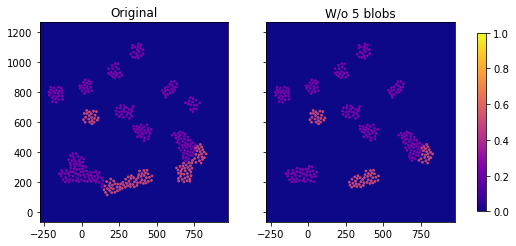

In [3]:
h1.plot([x_train[0], x_train_5[0]], ['Original', 'W/o 5 blobs'], show=True, save=True, \
       plot_name='models_log/stimuli_new/blobs.pdf')

In [ ]:
def create_data(times_ids=times_ids, batches_200=batches_200,
    GID_to_num=GID_to_num, missing_blobs=0):

    x_data = []
    for batch in batches_200:
        if missing_blobs != 0:
            unique_blobs = [list(x) for x in set(tuple(x)
                for x in times_ids[batch])]
            choice = list(np.random.choice(unique_blobs,
                len(unique_blobs) - missing_blobs, False))
            chosen = [x for x in times_ids[batch] if x in choice]
            batch_gids = np.concatenate(chosen)
        else:
            batch_gids = np.concatenate(times_ids[batch])
        batch_gid_nums = [GID_to_num[key] for key in batch_gids]
        data = np.bincount(batch_gid_nums)
        data = np.concatenate((data, np.zeros(len(
            GID_to_num.keys()) - len(data))))
        x_data.append(data)
    x_data = np.array(x_data)
    x_data = x_data / np.max(x_data)
    return x_data

# Autoencoders

- For this dataset, activations are **bounded** (normalised to \[0, 1\]) and **non-binary** in nature.
    - Therefore, we should use **sigmoid activation** with **mean squared error**.

## Sparse <a class="anchor" id="sparse"></a>

In [110]:
autoencoder, encoder, decoder = h2.build_autoenc(input_shape=(2170,), encoding_dim=128)
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_95 (InputLayer)        (None, 2170)              0         
_________________________________________________________________
dense_94 (Dense)             (None, 128)               277888    
_________________________________________________________________
dense_95 (Dense)             (None, 2170)              279930    
Total params: 557,818
Trainable params: 557,818
Non-trainable params: 0
_________________________________________________________________


In [229]:
history_encdim = AppendedHistory(varname='enc_dim, num_hid', keys=['loss'])
callback = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, restore_best_weights=True)
encoding_dims = [8, 16]
num_hids = [0, 1, 2, 3, 4]
for encoding_dim in encoding_dims:
    for num_hid in num_hids:
        print('\nencoding_dim = {}'.format(encoding_dim))
        print('num_hid = {}\n'.format(num_hid))
        autoencoder, encoder = h2.build_deep_autoenc(encoding_dim=encoding_dim, input_shape=(2170,), num_hid=num_hid)
        %time history = autoencoder.fit(x_train, x_train, \
                                        epochs=50, \
                                        batch_size=1, \
                                        shuffle=True, \
                                        validation_data=(x_test, x_test), \
                                        verbose=0, callbacks=[callback])
        history_encdim.append_hist('{}, {}'.format(encoding_dim, num_hid), history)
        autoencoder.save('data/incite/models_log/stimuli_new/deep/autoencoder_{}_{}'.format(encoding_dim, num_hid))
        encoder.save('data/incite/models_log/stimuli_new/deep/encoder_{}_{}'.format(encoding_dim, num_hid))


encoding_dim = 8
num_hid = 0

CPU times: user 25.1 s, sys: 1.97 s, total: 27.1 s
Wall time: 21.1 s

encoding_dim = 8
num_hid = 1

CPU times: user 8min 49s, sys: 2min 38s, total: 11min 28s
Wall time: 3min 25s

encoding_dim = 8
num_hid = 2

CPU times: user 6min 54s, sys: 2min 3s, total: 8min 57s
Wall time: 2min 45s

encoding_dim = 8
num_hid = 3

CPU times: user 8min 40s, sys: 3min 18s, total: 11min 58s
Wall time: 3min 37s

encoding_dim = 8
num_hid = 4

CPU times: user 10min 50s, sys: 4min 59s, total: 15min 50s
Wall time: 4min 44s

encoding_dim = 16
num_hid = 0

CPU times: user 36.5 s, sys: 2.7 s, total: 39.2 s
Wall time: 29.3 s

encoding_dim = 16
num_hid = 1

CPU times: user 11min 34s, sys: 3min 35s, total: 15min 9s
Wall time: 4min 29s

encoding_dim = 16
num_hid = 2

CPU times: user 6min 35s, sys: 1min 51s, total: 8min 26s
Wall time: 2min 31s

encoding_dim = 16
num_hid = 3

CPU times: user 8min 49s, sys: 3min 16s, total: 12min 5s
Wall time: 3min 36s

encoding_dim = 16
num_hid = 4

CPU t

In [230]:
history_encdim.save('data/incite/models_log/stimuli_new/deep/histories_encdim_deep')

In [231]:
history_encdim = AppendedHistory(fname='data/incite/models_log/stimuli_new/deep/histories_encdim_deep')

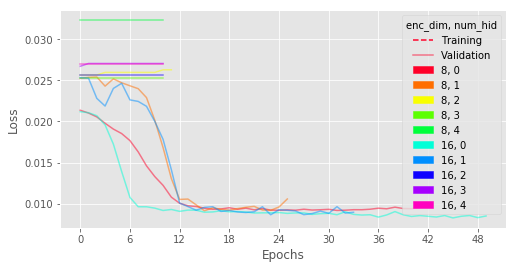

In [232]:
history_encdim.plot("", "val_loss", False, [0, 100], False, True, 'data/incite/models_log/stimuli_new/deep/histories_encdim_deep.pdf')

In [18]:
autoencoder = load_model('data/incite/models_log/stimuli_new/sparse/encoding_dim/autoencoder_128')
x_test_decoded = autoencoder.predict(x_test)
autoencoder_2 = load_model('data/incite/models_log/stimuli_new/sparse/encoding_dim/autoencoder_8')
x_test_decoded_2 = autoencoder.predict(x_test)

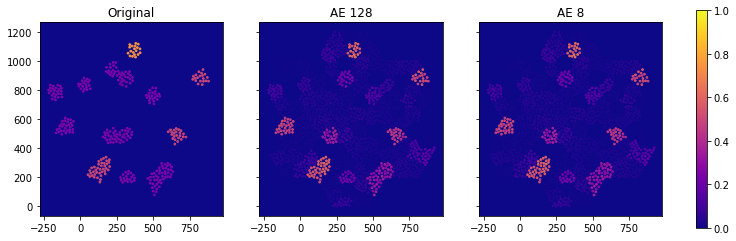

In [21]:
h1.plot([x_test[0], x_test_decoded[0], x_test_decoded_2[0]], ['Original', 'AE 128', 'AE 8'], show=True, save=True, \
       plot_name='models_log/stimuli_new/sparse/encoding_dim/decoded_comparison.pdf')

In [65]:
np.mean(x_test), np.mean(x_test_decoded), np.mean(x_test_decoded_2)

(0.062176227554425555, 0.07088892, 0.07088892)

In [66]:
np.std(x_test), np.std(x_test_decoded), np.std(x_test_decoded_2)

(0.1465359569451785, 0.1314671, 0.1314671)

In [196]:
history_readout = AppendedHistory(varname='round', keys=['loss', 'acc'])

In [235]:
history_readout = AppendedHistory(varname='enc_dim, num_hid', keys=['loss', 'acc'])
callback = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, restore_best_weights=True)
encoding_dims = [8, 16]
num_hids = [0, 1, 2, 3, 4]
for encoding_dim in encoding_dims:
    for num_hid in num_hids:
        print('\nencoding_dim = {}'.format(encoding_dim))
        print('num_hid = {}\n'.format(num_hid))
        encoder = load_model('data/incite/models_log/stimuli_new/deep/encoder_{}_{}'.format(encoding_dim, num_hid))
        #x_train_pred = encoder.predict(x_train)
        #x_test_pred = encoder.predict(x_test)
        readout = h2.build_readout(encoder, output_dim=8)
        %time history = readout.fit(x_train, y_train_hot, \
                                    epochs=50, \
                                    batch_size=1, \
                                    shuffle=True, \
                                    validation_data=(x_test, y_test_hot), \
                                    verbose=0, callbacks=[callback])
        history.history['acc'] = history.history.pop('categorical_accuracy')
        history.history['val_acc'] = history.history.pop('val_categorical_accuracy')
        history_readout.append_hist('{}, {}'.format(encoding_dim, num_hid), history)
        readout.save('data/incite/models_log/stimuli_new/deep/readout/readout_{}_{}_paired'.format(encoding_dim, num_hid))


encoding_dim = 8
num_hid = 0



/Users/utanashati/miniconda3/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


CPU times: user 31.9 s, sys: 2.79 s, total: 34.7 s
Wall time: 27.9 s

encoding_dim = 8
num_hid = 1



/Users/utanashati/miniconda3/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


CPU times: user 8min 26s, sys: 2min 11s, total: 10min 38s
Wall time: 3min 42s

encoding_dim = 8
num_hid = 2



/Users/utanashati/miniconda3/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


CPU times: user 6min 56s, sys: 1min 55s, total: 8min 52s
Wall time: 2min 50s

encoding_dim = 8
num_hid = 3



/Users/utanashati/miniconda3/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


CPU times: user 5min 6s, sys: 1min 22s, total: 6min 29s
Wall time: 2min

encoding_dim = 8
num_hid = 4



/Users/utanashati/miniconda3/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


CPU times: user 5min 46s, sys: 1min 48s, total: 7min 35s
Wall time: 2min 19s

encoding_dim = 16
num_hid = 0



/Users/utanashati/miniconda3/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


CPU times: user 36.6 s, sys: 2.99 s, total: 39.6 s
Wall time: 31.7 s

encoding_dim = 16
num_hid = 1



/Users/utanashati/miniconda3/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


CPU times: user 5min 30s, sys: 1min 33s, total: 7min 3s
Wall time: 2min 29s

encoding_dim = 16
num_hid = 2



/Users/utanashati/miniconda3/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


CPU times: user 4min 31s, sys: 1min 21s, total: 5min 53s
Wall time: 1min 55s

encoding_dim = 16
num_hid = 3



/Users/utanashati/miniconda3/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


CPU times: user 5min, sys: 1min 24s, total: 6min 24s
Wall time: 2min 1s

encoding_dim = 16
num_hid = 4



/Users/utanashati/miniconda3/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


CPU times: user 25min 34s, sys: 7min 29s, total: 33min 4s
Wall time: 10min 8s


In [240]:
history_readout.save('data/incite/models_log/stimuli_new/deep/readout/histories_readout_paired')

In [241]:
history_readout = AppendedHistory(fname='data/incite/models_log/stimuli_new/deep/readout/histories_readout_paired')

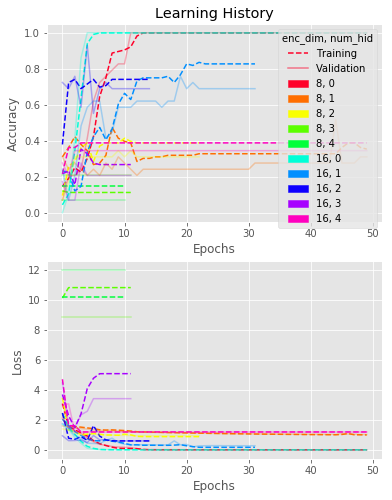

In [242]:
history_readout.plot_acc_loss("Learning History", "", "val_", save=True,
                              fname='data/incite/models_log/stimuli_new/deep/readout/pics/histories_readout_paired.pdf')

In [243]:
history_readout = AppendedHistory(varname='enc_dim, num_hid', keys=['loss', 'acc'])
callback = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, restore_best_weights=True)
encoding_dims = [8, 16]
num_hids = [0, 1, 2, 3, 4]
for encoding_dim in encoding_dims:
    for num_hid in num_hids:
        print('\nencoding_dim = {}'.format(encoding_dim))
        print('num_hid = {}\n'.format(num_hid))
        encoder = load_model('data/incite/models_log/stimuli_new/deep/encoder_{}_{}'.format(encoding_dim, num_hid))
        x_train_pred = encoder.predict(x_train)
        x_test_pred = encoder.predict(x_test)
        readout = h2.build_readout(input_shape=(encoding_dim,), output_dim=8)
        %time history = readout.fit(x_train_pred, y_train_hot, \
                                    epochs=50, \
                                    batch_size=1, \
                                    shuffle=True, \
                                    validation_data=(x_test_pred, y_test_hot), \
                                    verbose=0, callbacks=[callback])
        history.history['acc'] = history.history.pop('categorical_accuracy')
        history.history['val_acc'] = history.history.pop('val_categorical_accuracy')
        history_readout.append_hist('{}, {}'.format(encoding_dim, num_hid), history)
        readout.save('data/incite/models_log/stimuli_new/deep/readout/readout_{}_{}_unpaired'.format(encoding_dim, num_hid))


encoding_dim = 8
num_hid = 0



/Users/utanashati/miniconda3/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


CPU times: user 30.1 s, sys: 2.18 s, total: 32.3 s
Wall time: 27.4 s

encoding_dim = 8
num_hid = 1



/Users/utanashati/miniconda3/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


CPU times: user 28.9 s, sys: 2.14 s, total: 31 s
Wall time: 26 s

encoding_dim = 8
num_hid = 2



/Users/utanashati/miniconda3/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


CPU times: user 19.4 s, sys: 1.19 s, total: 20.6 s
Wall time: 17.9 s

encoding_dim = 8
num_hid = 3



/Users/utanashati/miniconda3/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


CPU times: user 12.3 s, sys: 543 ms, total: 12.8 s
Wall time: 11.7 s

encoding_dim = 8
num_hid = 4



/Users/utanashati/miniconda3/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


CPU times: user 12.3 s, sys: 542 ms, total: 12.9 s
Wall time: 11.8 s

encoding_dim = 16
num_hid = 0



/Users/utanashati/miniconda3/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


CPU times: user 30.8 s, sys: 2.19 s, total: 33 s
Wall time: 28.1 s

encoding_dim = 16
num_hid = 1



/Users/utanashati/miniconda3/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


CPU times: user 29.3 s, sys: 2.14 s, total: 31.5 s
Wall time: 26.3 s

encoding_dim = 16
num_hid = 2



/Users/utanashati/miniconda3/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


CPU times: user 25.8 s, sys: 2.41 s, total: 28.2 s
Wall time: 24.7 s

encoding_dim = 16
num_hid = 3



/Users/utanashati/miniconda3/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


CPU times: user 21.5 s, sys: 1.32 s, total: 22.8 s
Wall time: 19.8 s

encoding_dim = 16
num_hid = 4



/Users/utanashati/miniconda3/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


CPU times: user 17.1 s, sys: 947 ms, total: 18.1 s
Wall time: 16.1 s


In [184]:
history_readout.save('data/incite/models_log/stimuli_new/sparse/encoding_dim/readout/history_readout_paired')

In [185]:
history_readout = AppendedHistory(fname='data/incite/models_log/stimuli_new/sparse/encoding_dim/readout/history_readout_paired')

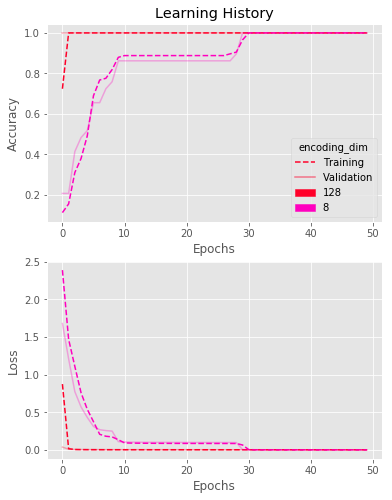

In [186]:
history_readout.plot_acc_loss("Learning History", "", "val_", save=True,
                              fname='data/incite/models_log/stimuli_new/sparse/encoding_dim/readout/history_readout_paired.pdf')

In [90]:
ro = load_model('data/incite/models_log/stimuli_new/readout_in')

In [96]:
%time ls_mean, acs_mean, ls_std, acs_std = h1.get_ro(ro, y_test_hot, max_pixels=11, num_rounds=100, step=1)
with open('data/incite/models_log/stimuli_new/ls_mean_in.pkl', 'wb') as f:
    pkl.dump(ls_mean, f)
with open('data/incite/models_log/stimuli_new/acs_mean_in.pkl', 'wb') as f:
    pkl.dump(acs_mean, f)
with open('data/incite/models_log/stimuli_new/ls_std_in.pkl', 'wb') as f:
    pkl.dump(ls_std, f)
with open('data/incite/models_log/stimuli_new/acs_std_in.pkl', 'wb') as f:
    pkl.dump(acs_std, f)

0
CPU times: user 49.7 s, sys: 1.12 s, total: 50.8 s
Wall time: 51.7 s


In [7]:
encoding_dims = [8, 16]
num_hids = [0, 1, 2, 3, 4]
for encoding_dim in encoding_dims:
    for num_hid in num_hids:
        print('\nencoding_dim = {}'.format(encoding_dim))
        print('num_hid = {}\n'.format(num_hid))
        #encoder = load_model('data/incite/models_log/stimuli_new/deep/encoder_{}_{}'.format(encoding_dim, num_hid))
        ro = load_model('data/incite/models_log/stimuli_new/deep/readout/readout_{}_{}_paired'.format(encoding_dim, num_hid))
        %time ls_mean, acs_mean, ls_std, acs_std = h1.get_ro(ro, y_test_hot, max_pixels=11, num_rounds=100, step=1)
        with open('data/incite/models_log/stimuli_new/deep/readout/ls_mean_{}_{}_finetuning.pkl'.format(encoding_dim, num_hid), 'wb') as f:
            pkl.dump(ls_mean, f)
        with open('data/incite/models_log/stimuli_new/deep/readout/acs_mean_{}_{}_finetuning.pkl'.format(encoding_dim, num_hid), 'wb') as f:
            pkl.dump(acs_mean, f)
        with open('data/incite/models_log/stimuli_new/deep/readout/ls_std_{}_{}_finetuning.pkl'.format(encoding_dim, num_hid), 'wb') as f:
            pkl.dump(ls_std, f)
        with open('data/incite/models_log/stimuli_new/deep/readout/acs_std_{}_{}_finetuning.pkl'.format(encoding_dim, num_hid), 'wb') as f:
            pkl.dump(acs_std, f)


encoding_dim = 8
num_hid = 0

0
CPU times: user 44.7 s, sys: 1.01 s, total: 45.7 s
Wall time: 45.7 s

encoding_dim = 8
num_hid = 1

0
CPU times: user 1min, sys: 1.75 s, total: 1min 2s
Wall time: 50.5 s

encoding_dim = 8
num_hid = 2

0
CPU times: user 1min 14s, sys: 2.38 s, total: 1min 17s
Wall time: 59.2 s

encoding_dim = 8
num_hid = 3

0
CPU times: user 1min 25s, sys: 3.33 s, total: 1min 28s
Wall time: 1min

encoding_dim = 8
num_hid = 4

0
CPU times: user 1min 37s, sys: 3.59 s, total: 1min 40s
Wall time: 1min 7s

encoding_dim = 16
num_hid = 0

0
CPU times: user 46.5 s, sys: 1.15 s, total: 47.7 s
Wall time: 47.8 s

encoding_dim = 16
num_hid = 1

0
CPU times: user 1min 3s, sys: 1.72 s, total: 1min 5s
Wall time: 54.4 s

encoding_dim = 16
num_hid = 2

0
CPU times: user 1min 15s, sys: 2.4 s, total: 1min 18s
Wall time: 59 s

encoding_dim = 16
num_hid = 3

0
CPU times: user 1min 27s, sys: 3.15 s, total: 1min 30s
Wall time: 1min 3s

encoding_dim = 16
num_hid = 4

0
CPU times: user 1min 39s, 

In [53]:
encoding_dims = [8, 128]
for encoding_dim in encoding_dims:
    print('\nencoding_dim = {}'.format(encoding_dim))
    encoder = load_model('data/incite/models_log/stimuli_new/sparse/encoding_dim/encoder_{}'.format(encoding_dim))
    ro = load_model('data/incite/models_log/stimuli_new/sparse/encoding_dim/readout/readout_{}'.format(encoding_dim))
    %time ls_mean, acs_mean, ls_std, acs_std = h1.get_ro_repr(ro, encoder, y_test_hot, max_pixels=11, num_rounds=100, step=1)
    with open('data/incite/models_log/stimuli_new/sparse/encoding_dim/readout/ls_mean_{}_frozenweights.pkl'.format(encoding_dim), 'wb') as f:
        pkl.dump(ls_mean, f)
    with open('data/incite/models_log/stimuli_new/sparse/encoding_dim/readout/acs_mean_{}_frozenweights.pkl'.format(encoding_dim), 'wb') as f:
        pkl.dump(acs_mean, f)
    with open('data/incite/models_log/stimuli_new/sparse/encoding_dim/readout/ls_std_{}_frozenweights.pkl'.format(encoding_dim), 'wb') as f:
        pkl.dump(ls_std, f)
    with open('data/incite/models_log/stimuli_new/sparse/encoding_dim/readout/acs_std_{}_frozenweights.pkl'.format(encoding_dim), 'wb') as f:
        pkl.dump(acs_std, f)


encoding_dim = 8


/Users/utanashati/miniconda3/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


CPU times: user 1min 11s, sys: 3.14 s, total: 1min 14s
Wall time: 1min 8s

encoding_dim = 128


/Users/utanashati/miniconda3/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


CPU times: user 1min 14s, sys: 3.22 s, total: 1min 17s
Wall time: 1min 11s


In [97]:
with open('data/incite/models_log/stimuli_new/ls_mean_in.pkl', 'rb') as f:
    ls_mean_in = pkl.load(f)
with open('data/incite/models_log/stimuli_new/acs_mean_in.pkl', 'rb') as f:
    acs_mean_in = pkl.load(f)
with open('data/incite/models_log/stimuli_new/acs_std_in.pkl', 'rb') as f:
    acs_std_in = pkl.load(f)
with open('data/incite/models_log/stimuli_new/ls_std_in.pkl', 'rb') as f:
    ls_std_in = pkl.load(f)
    
with open('data/incite/models_log/stimuli_new/sparse/encoding_dim/readout/ls_mean_8_frozenweights.pkl', 'rb') as f:
    ls_mean_8_fw = pkl.load(f)
with open('data/incite/models_log/stimuli_new/sparse/encoding_dim/readout/ls_mean_8_finetuning.pkl', 'rb') as f:
    ls_mean_8_ft = pkl.load(f)
with open('data/incite/models_log/stimuli_new/sparse/encoding_dim/readout/ls_mean_128_frozenweights.pkl', 'rb') as f:
    ls_mean_128_fw = pkl.load(f)
with open('data/incite/models_log/stimuli_new/sparse/encoding_dim/readout/ls_mean_128_finetuning.pkl', 'rb') as f:
    ls_mean_128_ft = pkl.load(f)
    
with open('data/incite/models_log/stimuli_new/sparse/encoding_dim/readout/ls_std_8_frozenweights.pkl', 'rb') as f:
    ls_std_8_fw = pkl.load(f)
with open('data/incite/models_log/stimuli_new/sparse/encoding_dim/readout/ls_std_8_finetuning.pkl', 'rb') as f:
    ls_std_8_ft = pkl.load(f)
with open('data/incite/models_log/stimuli_new/sparse/encoding_dim/readout/ls_std_128_frozenweights.pkl', 'rb') as f:
    ls_std_128_fw = pkl.load(f)
with open('data/incite/models_log/stimuli_new/sparse/encoding_dim/readout/ls_std_128_finetuning.pkl', 'rb') as f:
    ls_std_128_ft = pkl.load(f)    
    
with open('data/incite/models_log/stimuli_new/sparse/encoding_dim/readout/acs_mean_8_frozenweights.pkl', 'rb') as f:
    acs_mean_8_fw = pkl.load(f)
with open('data/incite/models_log/stimuli_new/sparse/encoding_dim/readout/acs_mean_8_finetuning.pkl', 'rb') as f:
    acs_mean_8_ft = pkl.load(f)
with open('data/incite/models_log/stimuli_new/sparse/encoding_dim/readout/acs_mean_128_frozenweights.pkl', 'rb') as f:
    acs_mean_128_fw = pkl.load(f)
with open('data/incite/models_log/stimuli_new/sparse/encoding_dim/readout/acs_mean_128_finetuning.pkl', 'rb') as f:
    acs_mean_128_ft = pkl.load(f)
    
with open('data/incite/models_log/stimuli_new/sparse/encoding_dim/readout/acs_std_8_frozenweights.pkl', 'rb') as f:
    acs_std_8_fw = pkl.load(f)
with open('data/incite/models_log/stimuli_new/sparse/encoding_dim/readout/acs_std_8_finetuning.pkl', 'rb') as f:
    acs_std_8_ft = pkl.load(f)
with open('data/incite/models_log/stimuli_new/sparse/encoding_dim/readout/acs_std_128_frozenweights.pkl', 'rb') as f:
    acs_std_128_fw = pkl.load(f)
with open('data/incite/models_log/stimuli_new/sparse/encoding_dim/readout/acs_std_128_finetuning.pkl', 'rb') as f:
    acs_std_128_ft = pkl.load(f)

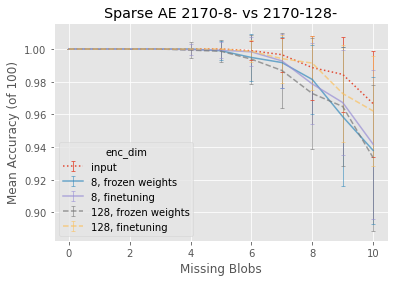

In [99]:
with plt.style.context('ggplot'):
    plt.errorbar(np.arange(len(acs_mean_in)), acs_mean_in, yerr=acs_std_in, \
                 elinewidth=0.8, capsize=2, capthick=0.8, \
                 label='input', linestyle=':')
    plt.errorbar(np.arange(len(acs_mean_8_fw)), acs_mean_8_fw, yerr=acs_std_8_fw, \
                 elinewidth=0.8, capsize=2, capthick=0.8, \
                 label='8, frozen weights', alpha=0.7)
    plt.errorbar(np.arange(len(acs_mean_8_ft)), acs_mean_8_ft, yerr=acs_std_8_ft, \
                 elinewidth=0.8, capsize=2, capthick=0.8, \
                 label='8, finetuning', alpha=0.7)
    plt.errorbar(np.arange(len(acs_mean_128_fw)), acs_mean_128_fw, yerr=acs_std_128_fw, \
                 elinewidth=0.8, capsize=2, capthick=0.8, \
                 label='128, frozen weights', alpha=0.7, linestyle='--')
    plt.errorbar(np.arange(len(acs_mean_128_ft)), acs_mean_128_ft, yerr=acs_std_128_ft, \
                 elinewidth=0.8, capsize=2, capthick=0.8, \
                 label='128, finetuning', alpha=0.7, linestyle='--')
    plt.legend(title='enc_dim')
    plt.title('Sparse AE 2170-8- vs 2170-128-')
    plt.xlabel('Missing Blobs')
    plt.ylabel('Mean Accuracy (of 100)')
    plt.savefig('data/incite/models_log/stimuli_new/sparse/encoding_dim/pics/acc.pdf', dpi=300)
plt.show()

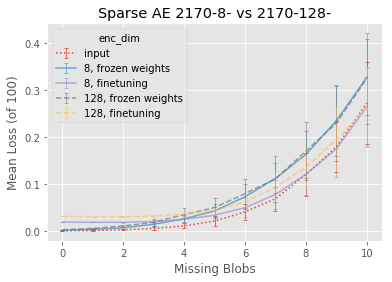

In [100]:
with plt.style.context('ggplot'):
    plt.errorbar(np.arange(len(ls_mean_in)), ls_mean_in, yerr=ls_std_in, \
                 elinewidth=0.8, capsize=2, capthick=0.8, \
                 label='input', linestyle=':')
    plt.errorbar(np.arange(len(ls_mean_8_fw)), ls_mean_8_fw, yerr=ls_std_8_fw, \
                 elinewidth=0.8, capsize=2, capthick=0.8, \
                 label='8, frozen weights', alpha=0.7)
    plt.errorbar(np.arange(len(ls_mean_8_ft)), ls_mean_8_ft, yerr=ls_std_8_ft, \
                 elinewidth=0.8, capsize=2, capthick=0.8, \
                 label='8, finetuning', alpha=0.7)
    plt.errorbar(np.arange(len(ls_mean_128_fw)), ls_mean_128_fw, yerr=ls_std_128_fw, \
                 elinewidth=0.8, capsize=2, capthick=0.8, \
                 label='128, frozen weights', alpha=0.7, linestyle='--')
    plt.errorbar(np.arange(len(ls_mean_128_ft)), ls_mean_128_ft, yerr=ls_std_128_ft, \
                 elinewidth=0.8, capsize=2, capthick=0.8, \
                 label='128, finetuning', alpha=0.7, linestyle='--')
    plt.legend(title='enc_dim')
    plt.title('Sparse AE 2170-8- vs 2170-128-')
    plt.xlabel('Missing Blobs')
    plt.ylabel('Mean Loss (of 100)')
    plt.savefig('data/incite/models_log/stimuli_new/sparse/encoding_dim/pics/loss.pdf', dpi=300)
plt.show()

In [101]:
encoding_dims = [8, 16]
num_hids = [0, 1, 2, 3, 4]
with plt.style.context('ggplot'):
    for num_hid in num_hids:
        plt.errorbar(np.arange(len(ls_mean_in)), ls_mean_in, yerr=ls_std_in, \
                     elinewidth=0.8, capsize=2, capthick=0.8, \
                     label='input', linestyle=':')
        for encoding_dim in encoding_dims:
            with open('data/incite/models_log/stimuli_new/deep/readout/ls_mean_{}_{}_finetuning.pkl'.format(encoding_dim, num_hid), 'rb') as f:
                ls_mean_ft = pkl.load(f)
            with open('data/incite/models_log/stimuli_new/deep/readout/ls_std_{}_{}_finetuning.pkl'.format(encoding_dim, num_hid), 'rb') as f:
                ls_std_ft = pkl.load(f)
            plt.errorbar(np.arange(len(ls_mean_ft)), ls_mean_ft, yerr=ls_std_ft, \
                         elinewidth=0.8, capsize=1.5, capthick=0.8, \
                         label='{}, {}, finetuning'.format(encoding_dim, num_hid), alpha=0.7)
            with open('data/incite/models_log/stimuli_new/deep/readout/ls_mean_{}_{}_frozenweights.pkl'.format(encoding_dim, num_hid), 'rb') as f:
                ls_mean_fw = pkl.load(f)
            with open('data/incite/models_log/stimuli_new/deep/readout/ls_std_{}_{}_frozenweights.pkl'.format(encoding_dim, num_hid), 'rb') as f:
                ls_std_fw = pkl.load(f)
            plt.errorbar(np.arange(len(ls_mean_fw)), ls_mean_fw, yerr=ls_std_fw, \
                         elinewidth=0.8, capsize=2, capthick=0.8, \
                         label='{}, {}, frozen weights'.format(encoding_dim, num_hid), alpha=0.7, linestyle='--')
            plt.legend(title='enc_dim, num_hid')
            plt.title('Deep AEs')
            plt.xlabel('Missing Blobs')
            plt.ylabel('Mean Loss (of 100)')
        plt.savefig('data/incite/models_log/stimuli_new/deep/readout/pics/loss_{}.pdf'.format(num_hid), dpi=300)
        plt.clf()
        

In [102]:
encoding_dims = [8, 16]
num_hids = [0, 1, 2, 3, 4]
with plt.style.context('ggplot'):
    for num_hid in num_hids:
        plt.errorbar(np.arange(len(acs_mean_in)), acs_mean_in, yerr=acs_std_in, \
                     elinewidth=0.8, capsize=2, capthick=0.8, \
                     label='input', linestyle=':')
        for encoding_dim in encoding_dims:
            with open('data/incite/models_log/stimuli_new/deep/readout/acs_mean_{}_{}_finetuning.pkl'.format(encoding_dim, num_hid), 'rb') as f:
                acs_mean_ft = pkl.load(f)
            with open('data/incite/models_log/stimuli_new/deep/readout/acs_std_{}_{}_finetuning.pkl'.format(encoding_dim, num_hid), 'rb') as f:
                acs_std_ft = pkl.load(f)
            plt.errorbar(np.arange(len(acs_mean_ft)), acs_mean_ft, yerr=acs_std_ft, \
                         elinewidth=0.8, capsize=1.5, capthick=0.8, \
                         label='{}, {}, finetuning'.format(encoding_dim, num_hid), alpha=0.7)
            with open('data/incite/models_log/stimuli_new/deep/readout/acs_mean_{}_{}_frozenweights.pkl'.format(encoding_dim, num_hid), 'rb') as f:
                acs_mean_fw = pkl.load(f)
            with open('data/incite/models_log/stimuli_new/deep/readout/acs_std_{}_{}_frozenweights.pkl'.format(encoding_dim, num_hid), 'rb') as f:
                acs_std_fw = pkl.load(f)
            plt.errorbar(np.arange(len(acs_mean_fw)), acs_mean_fw, yerr=acs_std_fw, \
                         elinewidth=0.8, capsize=2, capthick=0.8, \
                         label='{}, {}, frozen weights'.format(encoding_dim, num_hid), alpha=0.7, linestyle='--')
            plt.legend(title='enc_dim, num_hid')
            plt.title('Deep AEs')
            plt.xlabel('Missing Blobs')
            plt.ylabel('Mean Accuracy (of 100)')
        plt.savefig('data/incite/models_log/stimuli_new/deep/readout/pics/acc_{}.pdf'.format(num_hid), dpi=300)
        plt.clf()
        

### Pattern Distributions

In [63]:
with open('data/input/stim_train.pkl', 'rb') as f:
    stim_train = pkl.load(f)

In [64]:
# `d_data` - dictionary of all indices of each pattern, dict.
d_data = {}
for i in np.unique(stim_train):
    d_data[i] = np.argwhere(stim_train == i).reshape(-1)

In [65]:
d_test = {key: d_data[key][np.where(d_data[key] >= 116)]-116 for key in d_data.keys()}

In [73]:
encoder = load_model('data/incite/models_log/stimuli_new/deep/encoder_8_0')

/Users/utanashati/miniconda3/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [74]:
encoded_imgs = encoder.predict(x_test)

In [75]:
# `distribs` - distributions of encoded representations for each test pattern, list of 1darrays.
def get_distribs(encoded_imgs):
    distribs = []
    for key in d_test.keys():
        distrib = []
        for i in d_test[key]:
            distrib.append(encoded_imgs[i])
        distrib = np.array(distrib)
        distribs.append(distrib)
    return distribs

In [86]:
def plot_distribs(distribs, title='', add='', rfolder='stimuli_new/pattern_distribs/'):
    with plt.style.context('ggplot'):
        for i, key in enumerate(d_test.keys()):
            fig, ax = plt.subplots(figsize=(6, 4))
            ax.set_ylim(0, 20)
            for distrib in distribs[i]:
                arr = np.vstack((np.arange(8)+1, distrib)).T
                ax.scatter(arr[:, 0], arr[:, 1], alpha=0.7)
            ax.set_title("{}Pattern {}".format(title, key))
            ax.set_xlabel('Representation Dimension')
            ax.set_ylabel('Encoded Value')
            fig.savefig("data/incite/models_log/{}pattern_distrib_{}{}.pdf".format(rfolder, key, add), dpi=300)

In [78]:
plot_distribs(get_distribs(encoded_imgs), title='Simple AE: ', add='')

/Users/utanashati/miniconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


In [82]:
def plot_error_distribs(encoder, max_blobs=11):
    for i in range(max_blobs):
        data = h1.get_train_test(h1.create_data(missing_blobs=i))[1]
        encoded_imgs = encoder.predict(data)
        plot_distribs(get_distribs(encoded_imgs), title='W/o {} blobs: '.format(i), \
                      add='_ec_{}'.format(i), rfolder='stimuli_new/pattern_distribs/')

In [87]:
plot_error_distribs(encoder)

/Users/utanashati/miniconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
